In [1]:
%pip install pandas
%pip install matplotlib
%pip install nltk
%pip install wordcloud
%pip install scikit-learn==1.3.2
%pip install scikit-fuzzy==0.4.2
# Import pakietów
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import joblib
import pickle


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alicj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alicj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Załaduj dane
data_path = "joined_data.csv"
data = pd.read_csv(data_path)

In [3]:
print(data.head())

   Unnamed: 0                                               Body  Label
0           0  Subject: congratulations\n vince ,\n congratul...      0
1           1  \nhttp://news.bbc.co.uk/1/hi/scotland/2515231....      0
2           2  Big and big\nMAIN PAGE\nHuge big titties @ big...      1
3           3  Subject: re : enron visit - - thanks\n larry ,...      0
4           4  On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...      0


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18651 entries, 0 to 18650
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18651 non-null  int64 
 1   Body        18650 non-null  object
 2   Label       18651 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 437.3+ KB
None


In [5]:
data

Unnamed: 0                                               Body  Label
0               0  Subject: congratulations\n vince ,\n congratul...      0
1               1  \nhttp://news.bbc.co.uk/1/hi/scotland/2515231....      0
2               2  Big and big\nMAIN PAGE\nHuge big titties @ big...      1
3               3  Subject: re : enron visit - - thanks\n larry ,...      0
4               4  On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...      0
...           ...                                                ...    ...
18646       18646  Subject: fluid analysis\n our customer speak v...      1
18647       18647  Subject: guadalupe\n i rolled 740208 , 740209 ...      0
18648       18648  100% Free Porn!\nWhat more can you ask for?\nC...      1
18649       18649  Subject: revised nominations\n daren ,\n we ha...      0
18650       18650  Hello,\nI've got a small problem but still ann...      0

[18651 rows x 3 columns]

In [6]:
# Usuwamy NaN

In [7]:
data.dropna(inplace=True)

In [8]:
# Usuwamy puste wiadomości i wiadomości zawierające jedynie "\n"

In [9]:
data = data[data['Body'] != '\n']

In [10]:
data = data[data['Body'] != 'empty']

In [11]:
data.reset_index(drop=True, inplace=True)

In [12]:
data

Unnamed: 0                                               Body  Label
0               0  Subject: congratulations\n vince ,\n congratul...      0
1               1  \nhttp://news.bbc.co.uk/1/hi/scotland/2515231....      0
2               2  Big and big\nMAIN PAGE\nHuge big titties @ big...      1
3               3  Subject: re : enron visit - - thanks\n larry ,...      0
4               4  On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...      0
...           ...                                                ...    ...
18109       18646  Subject: fluid analysis\n our customer speak v...      1
18110       18647  Subject: guadalupe\n i rolled 740208 , 740209 ...      0
18111       18648  100% Free Porn!\nWhat more can you ask for?\nC...      1
18112       18649  Subject: revised nominations\n daren ,\n we ha...      0
18113       18650  Hello,\nI've got a small problem but still ann...      0

[18114 rows x 3 columns]

In [13]:
# Sprawdźmy rozkład targetów
print(data['Label'].value_counts())

Label
0    11124
1     6990
Name: count, dtype: int64


In [14]:
# Analiza długości wiadomości

In [15]:
def get_len(row):
    try:
        return len(row)
    except:
        return row

In [16]:
data['message_length'] = data['Body'].apply(get_len)

In [17]:
data.sort_values(by='message_length')

Unnamed: 0                                               Body  Label  \
16293       16774                                           \n4623\n      1   
6071         6254                                        Subject: \n      1   
3683         3792                                        Subject: \n      1   
12843       13228                                        Subject: \n      1   
17867       18399                                        Subject: \n      1   
...           ...                                                ...    ...   
6927         7128  ------------------------ Yahoo! Groups Sponsor...      0   
6887         7088  Subject: enron mentions\n enron discusses cred...      0   
2422         2488   =?GB2312?B?yNW12squ0ru97NbQufq5+rzKtefX08nosb...      1   
1522         1569  change your settings: http://blo.gs/settings.p...      0   
4844         4987  ,Body,Label\n 0,"Subject: great part-time or s...      0   

       message_length  
16293               6  
6071               10  
3683               10  
12843              10  
17867              10  
...               ...  
6927           107989  
6887           121502  
2422           129635  
1522           194978  
4844         17085626  

[18114 rows x 4 columns]

In [18]:
# Jedna wiadomość jest bardzo długa 17085626

In [19]:
data['message_length'].value_counts()

message_length
293     68
295     53
291     52
539     44
446     40
        ..
2394     1
4856     1
6192     1
2597     1
4004     1
Name: count, Length: 4903, dtype: int64

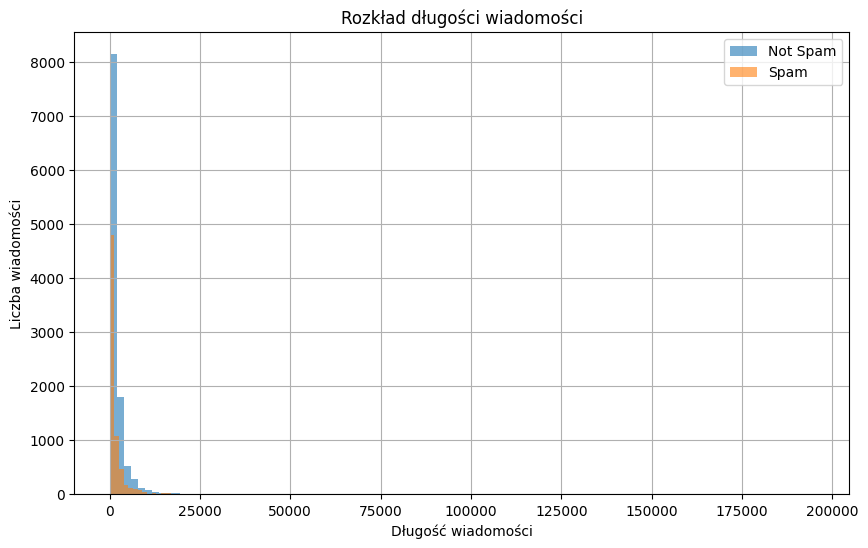

In [20]:
# Histogram długości wiadomości dla każdej kategorii - ograniczamy do 200.000 znaków celem wyświetlenia histogramów
hist_data = data[data['message_length'] < 200000]
plt.figure(figsize=(10, 6))
hist_data[hist_data['Label'] == 0]['message_length'].hist(bins=100, alpha=0.6, label='Not Spam')
hist_data[hist_data['Label'] == 1]['message_length'].hist(bins=100, alpha=0.6, label='Spam')
plt.legend()
plt.xlabel('Długość wiadomości')
plt.ylabel('Liczba wiadomości')
plt.title('Rozkład długości wiadomości')
plt.show()

In [21]:
# Ograniczamy jeszcze bardziej 

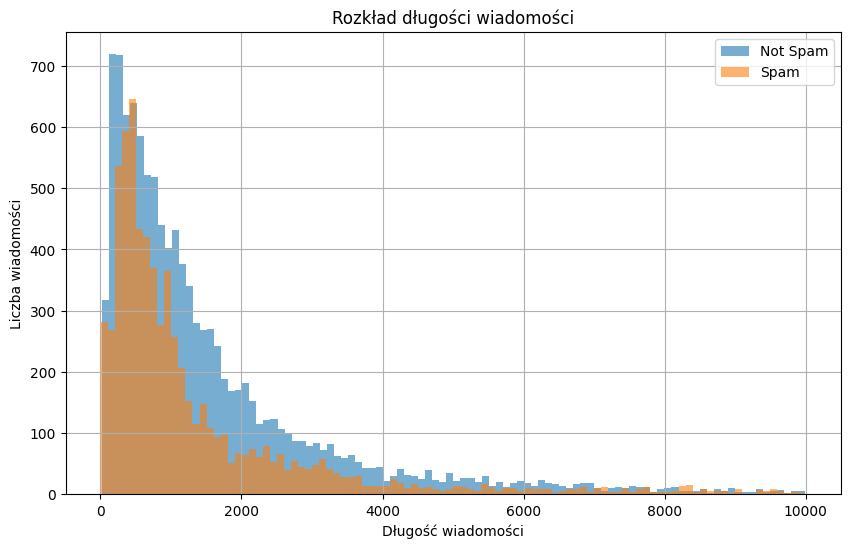

In [22]:
# Histogram długości wiadomości dla każdej kategorii - ograniczamy do 10000 znaków celem wyświetlenia histogramów
hist_data = data[data['message_length'] < 10000]
plt.figure(figsize=(10, 6))
hist_data[hist_data['Label'] == 0]['message_length'].hist(bins=100, alpha=0.6, label='Not Spam')
hist_data[hist_data['Label'] == 1]['message_length'].hist(bins=100, alpha=0.6, label='Spam')
plt.legend()
plt.xlabel('Długość wiadomości')
plt.ylabel('Liczba wiadomości')
plt.title('Rozkład długości wiadomości')
plt.show()

In [23]:
# Można zauważyć, że trudno odróżnić widomości po samej długości. W tym celu należy skorzystać z bardziej zaawansowanych metod.

In [24]:
# Przetwarzanie tekstu

In [25]:
data

Unnamed: 0                                               Body  Label  \
0               0  Subject: congratulations\n vince ,\n congratul...      0   
1               1  \nhttp://news.bbc.co.uk/1/hi/scotland/2515231....      0   
2               2  Big and big\nMAIN PAGE\nHuge big titties @ big...      1   
3               3  Subject: re : enron visit - - thanks\n larry ,...      0   
4               4  On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...      0   
...           ...                                                ...    ...   
18109       18646  Subject: fluid analysis\n our customer speak v...      1   
18110       18647  Subject: guadalupe\n i rolled 740208 , 740209 ...      0   
18111       18648  100% Free Porn!\nWhat more can you ask for?\nC...      1   
18112       18649  Subject: revised nominations\n daren ,\n we ha...      0   
18113       18650  Hello,\nI've got a small problem but still ann...      0   

       message_length  
0                 129  
1                 435  
2                 231  
3                1180  
4                 574  
...               ...  
18109             927  
18110             337  
18111             345  
18112             346  
18113             744  

[18114 rows x 4 columns]

In [26]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    # Usuwanie znaków specjalnych i tokenizacja
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    # Usuwanie stopwords i stemming
    words = [ps.stem(word) for word in words if word.lower() not in stop_words]
    return " ".join(words)

In [27]:
# Ten proces jest czasochłonny

In [28]:
data['processed_message'] = data['Body'].apply(preprocess_text)

In [29]:
data.head()

Unnamed: 0                                               Body  Label  \
0           0  Subject: congratulations\n vince ,\n congratul...      0   
1           1  \nhttp://news.bbc.co.uk/1/hi/scotland/2515231....      0   
2           2  Big and big\nMAIN PAGE\nHuge big titties @ big...      1   
3           3  Subject: re : enron visit - - thanks\n larry ,...      0   
4           4  On Fri, Aug 09, 2002 at 09:30:29AM +0100, Ryan...      0   

   message_length                                  processed_message  
0             129  subject congratul vinc congratul wish best luc...  
1             435  httpnewsbbccoukhiscotlandstm yahoo group spons...  
2             231  big big main page huge big titti bigbigscom sa...  
3            1180  subject enron visit thank larri think potenti ...  
4             574  fri aug ryan shane mention imho stop spammer g...

In [30]:
data['processed_message']

0        subject congratul vinc congratul wish best luc...
1        httpnewsbbccoukhiscotlandstm yahoo group spons...
2        big big main page huge big titti bigbigscom sa...
3        subject enron visit thank larri think potenti ...
4        fri aug ryan shane mention imho stop spammer g...
                               ...                        
18109    subject fluid analysi custom speak volum spur ...
18110    subject guadalup roll june ena deal guadalup d...
18111    free porn ask click â â â remov instruct striv...
18112    subject revis nomin daren receiv revis nomin p...
18113    hello ive got small problem still annoy upgrad...
Name: processed_message, Length: 18114, dtype: object

In [31]:
# Analiza słów za pomocą WordCloud
spam_words = ' '.join(list(data[data['Label'] == 1]['processed_message']))
not_spam_words = ' '.join(list(data[data['Label'] == 0]['processed_message']))

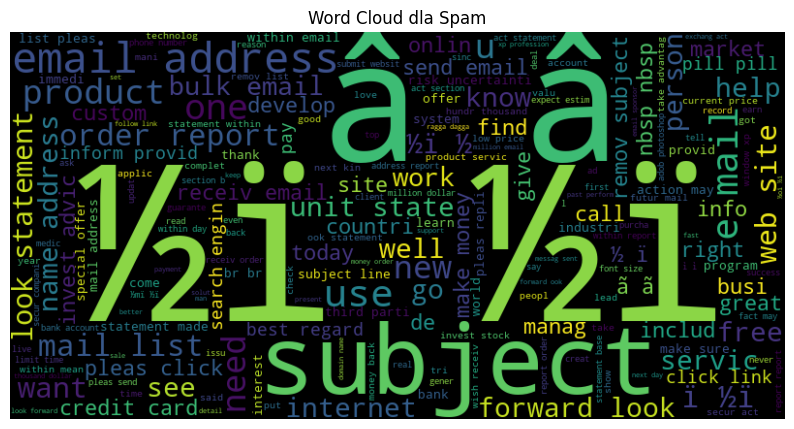

In [32]:
plt.figure(figsize=(10, 6))
wordcloud_spam = WordCloud(width=800, height=400).generate(spam_words)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dla Spam')
plt.show()

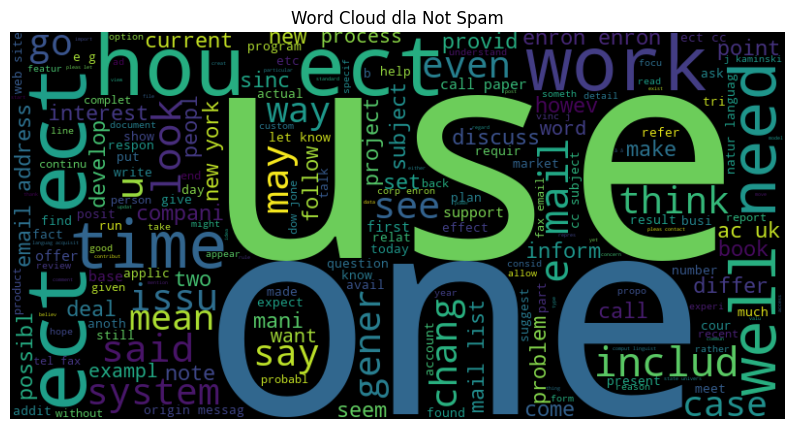

In [33]:
plt.figure(figsize=(10, 6))
wordcloud_not_spam = WordCloud(width=800, height=400).generate(not_spam_words)
plt.imshow(wordcloud_not_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dla Not Spam')
plt.show()

In [34]:
# Budowa modelu klasyfikacyjnego

In [35]:
# Zamiana tekstu na wektory
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_message'])
y = data['Label']

In [36]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Trenowanie modelu Naiwnego Bayesa
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

MultinomialNB()

In [38]:
# Predykcja i ocena Naiwny Bayes
y_pred_NB = model_NB.predict(X_test)
accuracy_NB = accuracy_score(y_test, y_pred_NB)
classification_rep_NB = classification_report(y_test, y_pred_NB)
confusion_matrix_NB = confusion_matrix(y_test, y_pred_NB)

In [39]:
accuracy_NB

0.9536295887386144

In [40]:
print(classification_rep_NB)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2229
           1       0.92      0.96      0.94      1394

    accuracy                           0.95      3623
   macro avg       0.95      0.96      0.95      3623
weighted avg       0.95      0.95      0.95      3623



In [41]:
print(confusion_matrix_NB)

[[2110  119]
 [  49 1345]]


In [42]:
# Trening Drzewa Decyzyjnego (DT)

In [43]:
# Parametry domyślne
model_DT = DecisionTreeClassifier(criterion= 'gini',
                                  max_depth= None,
                                  min_samples_leaf= 1,
                                  min_samples_split= 2,
                                  splitter= 'best')
model_DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
# Predykcja i ocena DT
y_pred_DT = model_DT.predict(X_test)
accuracy_DT = accuracy_score(y_test, y_pred_DT)
classification_rep_DT = classification_report(y_test, y_pred_DT)
confusion_matrix_DT = confusion_matrix(y_test, y_pred_DT)

In [45]:
accuracy_DT

0.9354126414573558

In [46]:
print(classification_rep_DT)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2229
           1       0.91      0.93      0.92      1394

    accuracy                           0.94      3623
   macro avg       0.93      0.93      0.93      3623
weighted avg       0.94      0.94      0.94      3623



In [47]:
print(confusion_matrix_DT)

[[2098  131]
 [ 103 1291]]


In [48]:
# Las losowy

In [49]:
model_RF = RandomForestClassifier(n_estimators= 100,
                                  bootstrap= True,
                                  ccp_alpha= 0.0,
                                  criterion= 'gini',
                                  max_depth= None,
                                  min_samples_leaf= 1,
                                  min_samples_split= 2,
                                  random_state=123)
model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [50]:
# Predykcja i ocena RF
y_pred_RF = model_RF.predict(X_test)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
classification_rep_RF = classification_report(y_test, y_pred_RF)
confusion_matrix_RF = confusion_matrix(y_test, y_pred_RF)

In [51]:
accuracy_RF

0.9770908087220536

In [52]:
print(classification_rep_RF)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2229
           1       0.98      0.96      0.97      1394

    accuracy                           0.98      3623
   macro avg       0.98      0.97      0.98      3623
weighted avg       0.98      0.98      0.98      3623



In [53]:
print(confusion_matrix_RF)

[[2201   28]
 [  55 1339]]


In [54]:
# Najlepszym modelem okazał się Las losowy - lepiej sklasyfikować spam jako wiadomość nie będącą spamem niż odwrotnie. 
# Dlatego wybieramy RF, a nie NB.

In [55]:
# Teraz dokonamy treningu na pełnych danych i zapiszemy model celem wykorzystania na danych rzeczywistych w późniejszej 
# aplikacji.

In [56]:
model_RF_full = RandomForestClassifier(n_estimators= 100,
                                  bootstrap= True,
                                  ccp_alpha= 0.0,
                                  criterion= 'gini',
                                  max_depth= None,
                                  min_samples_leaf= 1,
                                  min_samples_split= 2,
                                  random_state=123)

In [57]:
model_RF_full.fit(X, y)

RandomForestClassifier(random_state=123)

In [58]:
# Predykcja i ocena RF
y_pred_RF_full = model_RF_full.predict(X)
accuracy_RF_full = accuracy_score(y, y_pred_RF_full)
classification_rep_RF_full = classification_report(y, y_pred_RF_full)
confusion_matrix_RF_full = confusion_matrix(y, y_pred_RF_full)

In [59]:
accuracy_RF_full

1.0

In [60]:
print(classification_rep_RF_full)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11124
           1       1.00      1.00      1.00      6990

    accuracy                           1.00     18114
   macro avg       1.00      1.00      1.00     18114
weighted avg       1.00      1.00      1.00     18114



In [61]:
print(confusion_matrix_RF_full)

[[11124     0]
 [    0  6990]]


In [62]:
model_RF_full

RandomForestClassifier(random_state=123)

In [63]:
# Zapisz model i vectorizer
joblib.dump(model_RF_full, 'spam_classifier_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [64]:
# Uwaga, ważna jest zgodność wersji scikita i joblib tutaj i w środowisku aplikacji

In [65]:
pip freeze | findstr scikit

scikit-fuzzy==0.4.2
scikit-learn==1.3.2
Note: you may need to restart the kernel to use updated packages.


In [66]:
# Jak instalować?

In [67]:
# Np. tak
# pip install scikit-learn==1.3.2